# Titanic survival prediction for Kaggle competition

There are different methods to approach a binary classification problem such as the _Titanic survival_, each of them with advantages depending on the dataset size and independent variables to be used:

* Logistic regression is the most basic and popular classification algorithm.
* K-nearest neighbours (KNN) groups data points based on simmilarities. 
* Support vector machine (SPV) 
* Decission tree makes decissions based on if-else
* Neural network

Import relevant libraries

In [1]:
import numpy as np # for linear algebra
import pandas as pd # for data handling
import matplotlib.pyplot as plt

The data has been previoulsy split into train and test data. 
It is a better practice is to separate the data into train, dev and test samples in different proportions depending on dataset size; an usual split would be 10-10-80% respectively.

In [2]:
#df_train = pd.read_csv("data/train.csv", index_col='PassengerId')
#df_test  = pd.read_csv("data/test.csv", index_col='PassengerId')
df       = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

In [3]:
### FUNCTIONS TO EVENTUALLY MOVE ###
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
# use 'radial basic function'
# linear, polynomial and sigmoid also exist

import scipy.optimize as opt


def print_accuracy(y,yhat,message):
    print(message, metrics.accuracy_score(y, yhat))

def fit_predict(x_train,y_train,x_dev,y_dev,x_test,model,solver):
    
    if model=='knn':
        k=int(solver)
        fit = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)

    if model=='svc':
        fit = svm.SVC(kernel=solver).fit(x_train,y_train)
        
    if model=='lr':
        fit = LogisticRegression(C=0.01, solver=solver).fit(x_train,y_train)

    pred = fit.predict(x_test)
    print_accuracy(y_dev,fit.predict(x_dev),'Accuracy '+ model + ' ' + solver)

    return pred

def write_prediction(prediction,outname):
    df=pd.DataFrame(prediction)
    df.insert(0,'',range(892,1310,1),True) 
    df.columns=['PassengerId','Survived']
    df.to_csv(outname,index=False)


## Data exploration and manipulating
Let's explore the data to look at what kind of information we have, to see if there are any missing values or characters and standarize our sets.

In [4]:
print('Full train set tail\n', df.tail())
print('\n\nTest head\n', df_test.head())

Full train set tail
      PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q  


Test head
    PassengerId  Pclass                                          Name     Sex 

In [5]:
#Print train info/summary
print(df_test.info())
print('\n\n', df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


        PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.18120

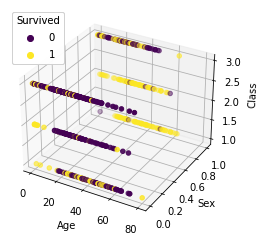

In [6]:
#replace string sex with binary
df['Sex'] = df['Sex'].replace(['male'],0)
df['Sex'] = df['Sex'].replace(['female'],1)
df_test['Sex'] = df_test['Sex'].replace(['male'],0)
df_test['Sex'] = df_test['Sex'].replace(['female'],1)

#change variable types
df['Sex'] = df['Sex'].astype('int')
df_test['Sex'] = df_test['Sex'].astype('int')
#the _y_ colum needs to be an integer
df['Survived'] = df['Survived'].astype('int')

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Class');

scatter = ax.scatter3D(df[['Age']], df[['Sex']], df[['Pclass']], c=df[['Survived']])
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="Survived")
ax.add_artist(legend1)

### Dealing with missing values

We see that 'Cabin' is obviously mostly NaN so let's get rid of that information. The ticket fare is reflected in the class 'Pclass' so we'll remove it too.
It wouldn't hurt to leave that column as the dataset is small but we might work with larger samples in the future.
For the other variables, we'd like to see how many different inputs there are so we can standarize the data.

In [7]:
drop_columns = ['Cabin', 'Fare', 'Name', 'Ticket']
df.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1, inplace=True)
df_test.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1, inplace=True)
#df_test.drop(columns=drop_columns, inplace=True)

In [8]:
#Print the unique values in the different train variables
mycols = ['Age', 'Sex', 'Pclass', 'Survived', 'SibSp', 'Parch']
mycols_test = ['Age', 'Sex', 'Pclass', 'SibSp', 'Parch']

print('=== Unique TRAIN values ===')
for col in mycols: 
    print('\n'+col+'\n', df[col].unique())
    
print('\n\n=== Unique TEST values ===')
for col in mycols_test: 
    print('\n'+col+'\n', df_test[col].unique())
    
df['Survived'].value_counts()

=== Unique TRAIN values ===

Age
 [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]

Sex
 [0 1]

Pclass
 [3 1 2]

Survived
 [0 1]

SibSp
 [1 0 3 4 2 5 8]

Parch
 [0 1 2 5 3 4 6]


=== Unique TEST values ===

Age
 [34.5  47.   62.   27.   22.   14.   30.   26.   18.   21.     nan 46.
 23.   63.   24.   35.   45.   55.    9.   48.   50.   22.5  41.   33.
 18.5  25.   39.   60.   36.   20.   28.   10.   17.   32.   13.   31.
 29.   28.5  32.5   6.   67.   49.    2.   76.   43.   16.    1.   12.
 42.   53.   26.5  40.  

0    549
1    342
Name: Survived, dtype: int64

We notice that there are a few entries where the age data is missing. As the percentage of missing age values is not negligible (about 20%), we'll avoid loosing data by taking the following approaches: Split male from females and
* Assign the mean of each gender ages
* Assign the mode of the specific gender age

In [9]:
from statistics import mean,mode

#define gender masks to compute values to use and to replace the 999s
m_mask = (df['Sex'] == 0)
f_mask = (df['Sex'] == 1)

#get gender age means
m_age_mean = df.loc[df['Sex'] == 0, 'Age'].mean()
f_age_mean = df.loc[df['Sex'] == 1, 'Age'].mean()
m_age_mode = mode(df.loc[df['Sex']==0, 'Age'])
f_age_mode = mode(df.loc[df['Sex']==1, 'Age'])

print('Mean | Mode')
print('Male: ',  m_age_mean, ' | ', m_age_mode)
print('Female: ',  f_age_mean, ' | ', f_age_mode)

# make df copies
df_drop = df[df.Age.notnull()]
df_drop_test = df_test[df_test.Age.notnull()]
df_mean = df.copy()
df_mean_test = df_test.copy()
df_mode = df.copy()
df_mode_test = df_test.copy()

# replace nulls with mean values
df_mean['Age'].mask(df_mean['Sex'] == 0 & (df_mean['Age'].isnull()), m_age_mean, inplace=True)
df_mean['Age'].mask(df_mean['Sex'] == 1 & (df_mean['Age'].isnull()), f_age_mean, inplace=True)
df_mean_test['Age'].mask(df_mean_test['Sex'] == 1 & (df_mean_test['Age'].isna()), m_age_mean, inplace=True)
df_mean_test['Age'].mask(df_mean_test['Sex'] == 0 & (df_mean_test['Age'].isna()), f_age_mean, inplace=True)
# replace nulls with mode values
df_mode['Age'].mask(df_mode['Sex'] == 0 & (df_mode['Age'].isnull()), m_age_mean, inplace=True)
df_mode['Age'].mask(df_mode['Sex'] == 1 & (df_mode['Age'].isnull()), f_age_mean, inplace=True)
df_mode_test['Age'].mask(df_mode_test['Sex'] == 1 & (df_mode_test['Age'].isna()), m_age_mean, inplace=True)
df_mode_test['Age'].mask(df_mode_test['Sex'] == 0 & (df_mode_test['Age'].isna()), f_age_mean, inplace=True)

print('\n\n\n',df_mean, '\n\n\n',df_mode)

Mean | Mode
Male:  30.72664459161148  |  28.0
Female:  27.915708812260537  |  24.0



      PassengerId  Survived  Pclass  Sex        Age  SibSp  Parch Embarked
0              1         0       3    0  27.915709      1      0        S
1              2         1       1    1  38.000000      1      0        C
2              3         1       3    1  26.000000      0      0        S
3              4         1       1    1  35.000000      1      0        S
4              5         0       3    0  27.915709      0      0        S
..           ...       ...     ...  ...        ...    ...    ...      ...
886          887         0       2    0  27.915709      0      0        S
887          888         1       1    1  19.000000      0      0        S
888          889         0       3    1  27.915709      1      2        S
889          890         1       1    0  27.915709      0      0        C
890          891         0       3    0  27.915709      0      0        Q

[891 rows x 8 columns] 


(array([18.,  6.,  8.,  5., 14., 38., 46., 44., 58., 40., 32., 27., 19.,
        19., 23., 15.,  9.,  6.,  7.,  8.,  4.,  2.,  3.,  1.,  1.]),
 array([ 0.42  ,  3.6032,  6.7864,  9.9696, 13.1528, 16.336 , 19.5192,
        22.7024, 25.8856, 29.0688, 32.252 , 35.4352, 38.6184, 41.8016,
        44.9848, 48.168 , 51.3512, 54.5344, 57.7176, 60.9008, 64.084 ,
        67.2672, 70.4504, 73.6336, 76.8168, 80.    ]),
 <BarContainer object of 25 artists>)

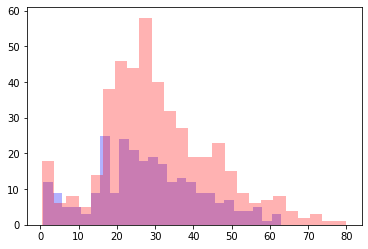

In [10]:
plt.hist(df['Age'].mask(m_mask), bins=25, alpha = 0.3, color='blue')
plt.hist(df['Age'].mask(f_mask), bins=25, alpha = 0.3, color='red')

Let's define X and y in the datasets considering only the variables that we consider relevant to the prediction.

In [11]:
model_cols = ['Age','Sex','Pclass']

X_drop = np.asarray(df_drop[model_cols])
X_mean = np.asarray(df_mean[model_cols])
X_mode = np.asarray(df_mode[model_cols])

y_drop = np.asarray(df_drop[['Survived']])
y_mean = np.asarray(df_mean[['Survived']])
y_mode = np.asarray(df_mode[['Survived']])

X_drop_test = np.asarray(df_drop_test[model_cols])
X_mean_test = np.asarray(df_mean_test[model_cols])
X_mode_test = np.asarray(df_mode_test[model_cols])

## Normalization

We also need to scale the data

In [12]:
from sklearn import preprocessing

X_drop = preprocessing.StandardScaler().fit(X_drop).transform(X_drop)
X_mode = preprocessing.StandardScaler().fit(X_mode).transform(X_mode)
X_mean = preprocessing.StandardScaler().fit(X_mean).transform(X_mean)
X_drop_test = preprocessing.StandardScaler().fit(X_mode_test).transform(X_drop_test)
X_mode_test = preprocessing.StandardScaler().fit(X_mode_test).transform(X_mode_test)
X_mean_test = preprocessing.StandardScaler().fit(X_mean_test).transform(X_mean_test)

X_mode[0:5]
X_mean[0:5]

array([[-4.66101891e-16, -7.37695132e-01,  8.27377244e-01],
       [ 1.32301886e+00,  1.35557354e+00, -1.56610693e+00],
       [-2.51333369e-01,  1.35557354e+00,  8.27377244e-01],
       [ 9.29430800e-01,  1.35557354e+00, -1.56610693e+00],
       [-4.66101891e-16, -7.37695132e-01,  8.27377244e-01]])

### Data split

In [13]:
from sklearn.model_selection import train_test_split

X_drop_train, X_drop_dev, y_drop_train, y_drop_dev = train_test_split( X_drop, y_drop, test_size=0.2, random_state=4)
X_mean_train, X_mean_dev, y_mean_train, y_mean_dev = train_test_split( X_mean, y_mean, test_size=0.2, random_state=4)
X_mode_train, X_mode_dev, y_mode_train, y_mode_dev = train_test_split( X_mode, y_mode, test_size=0.2, random_state=4)

y_drop_train = y_drop_train.reshape(y_drop_train.shape[0],) # reshape to no second dimension. that's the input for the class label.
y_drop_dev   = y_drop_dev.reshape(y_drop_dev.shape[0],) # reshape to no second dimension. that's the input for the class label.
y_mean_train = y_mean_train.reshape(y_mean_train.shape[0],) # reshape to no second dimension. that's the input for the class label.
y_mean_dev   = y_mean_dev.reshape(y_mean_dev.shape[0],) # reshape to no second dimension. that's the input for the class label.
y_mode_train = y_mode_train.reshape(y_mode_train.shape[0],) # reshape to no second dimension. that's the input for the class label.
y_mode_dev   = y_mode_dev.reshape(y_mode_dev.shape[0],) # reshape to no second dimension. that's the input for the class label.

print ('Train set:', X_mean_train.shape,  y_mean_train.shape)
print ('Dev set:', X_mean_dev.shape,  y_mean_dev.shape)

Train set: (712, 3) (712,)
Dev set: (179, 3) (179,)


## Binary Classification

Three models will be implemented to predict the survival of titanic passengers. 
The _train_ data set will be split into test and dev sets, and the test set will be used to compute the accuracy of each model.

In binary classification problems, the accuracy score (correctly classified set size / test set size) is equal to the jaccard_score function (intersection over union). Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.
from sklearn import metrics

### Logistic Regression

In [14]:
yhat_mean_lr = fit_predict(X_mean_train, y_mean_train, X_mean_dev, y_mean_dev, X_mean_test,'lr','lbfgs')
yhat_mode_lr = fit_predict(X_mode_train, y_mode_train, X_mode_dev, y_mode_dev, X_mode_test,'lr','lbfgs')

Accuracy lr lbfgs 0.8100558659217877
Accuracy lr lbfgs 0.8100558659217877


**predict_proba**  returns estimates for all classes (in our case 0 or 1), ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [15]:
#yprob_mean_lr = lr_mean.predict_proba(X_mean_test)
#yprob_mean_lr

**Output prediction**

In [16]:
write_prediction(yhat_mean_lr,'pred_mean_lr.csv')
write_prediction(yhat_mode_lr,'pred_mode_lr.csv')

## K-Nearest Neighbours

In [17]:
from sklearn.neighbors import KNeighborsClassifier

#Train Model and Predict using 5 neighbours for now
yhat_mean_knn = fit_predict(X_mean_train, y_mean_train, X_mean_dev, y_mean_dev, X_mean_test,'knn','5')
yhat_mode_knn = fit_predict(X_mode_train, y_mode_train, X_mode_dev, y_mode_dev, X_mode_test,'knn','5')

Accuracy knn 5 0.8547486033519553
Accuracy knn 5 0.8547486033519553


In [18]:
#output prediction
write_prediction(yhat_mean_knn,'pred_mean_knn.csv')
write_prediction(yhat_mode_knn,'pred_mode_knn.csv')

The accuracy is about 85% which is higher than the other two models. Could we imporve it further by changing the number of neighbours?

In [19]:
nk = 10
mean_acc = np.zeros((nk-1))
std_acc  = np.zeros((nk-1))

for n in range(1,nk):
    
    #Train Model and Predict
    # given that we're getting exactly same accuracies with mean and mode, lets only test on one
    neigh = KNeighborsClassifier(n_neighbors = nk).fit(X_mean_train,y_mean_train)
    yhat  = neigh.predict(X_mean_train)
    
    mean_acc[n-1] = metrics.accuracy_score(y_mean_dev, neigh.predict(X_mean_dev))
    std_acc[n-1] = np.std(yhat==y_mean_train)/np.sqrt(yhat.shape[0])

print('mean acc: ', mean_acc)
print('srt acc: ', std_acc)

mean acc:  [0.82122905 0.82122905 0.82122905 0.82122905 0.82122905 0.82122905
 0.82122905 0.82122905 0.82122905]
srt acc:  [0.01489505 0.01489505 0.01489505 0.01489505 0.01489505 0.01489505
 0.01489505 0.01489505 0.01489505]


## Support Vector Machine

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [20]:
yhat_mean_svc = fit_predict(X_mean_train, y_mean_train, X_mean_dev, y_mean_dev, X_mean_test,'svc','rbf')
yhat_mode_svc = fit_predict(X_mode_train, y_mode_train, X_mode_dev, y_mode_dev, X_mode_test,'svc','rbf')

Accuracy svc rbf 0.8100558659217877
Accuracy svc rbf 0.8100558659217877


In [21]:
#output prediction
write_prediction(yhat_mode_svc,'pred_mean_svc.csv')
write_prediction(yhat_mode_svc,'pred_mode_svc.csv')